# SMACE application example
## Settings

In [1]:
import json
import numpy as np
import pandas as pd
import warnings
from sklearn import linear_model
import xgboost
from sklearn import tree
import lime
import lime.lime_tabular

warnings.filterwarnings("ignore")
np.random.seed(seed=1)

In [2]:
from smace.rules import Rule
from smace.decisions import DM
from smace.explainer import Smace
from smace.models import Model
from smace import utils

**Data** is a uniform random sample $x_1,\ldots,x_6 \in [0,1]$.

In [3]:
# input data
data = np.random.rand(1000, 6)
columns = ['x1', 'x2', 'x3','x4','x5','x6']
df = pd.DataFrame(data, columns=columns)
df.head()

,x1,x2,x3,x4,x5,x6
0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339
1,0.186260,0.345561,0.396767,0.538817,0.419195,0.685220
2,0.204452,0.878117,0.027388,0.670468,0.417305,0.558690
3,0.140387,0.198101,0.800745,0.968262,0.313424,0.692323
4,0.876389,0.894607,0.085044,0.039055,0.169830,0.878143


We read the json file containing the **rules**.

In [4]:
# decision rules
with open('rules_example.json', 'r') as fp:
    rules_json = json.load(fp)

There are three machine learning models: 
* *lm*: LinearRegression trained to fit the function $f_1 = x_2 - 2x_3 + 8x_5 + x_6 $
* *xgb*: XGBRegressor trained to fit $ f_2 = -100x_1+80x_2x_4+50x_3 $
* *dtree*: DecisionTreeRegressor trained to fit $500\mathbb{1}_{x_4>0.5}$

In [5]:
# models
def f_1(x):
    return x[:, 1] - 2*x[:, 2] + 8*x[:, 4] + 9*x[:, 5]

def f_2(x):
    return -100*x[:, 0] + 80*x[:, 1]*x[:, 3] +  50*x[:, 2]

def f_3(x):
    if x.ndim == 1:
        x = np.expand_dims(x,0)
    return [500 if x[i,3]>0.5 else 0 for i in range(x.shape[0])]

X = df.values
y1 = f_1(X)
y2 = f_2(X)
y3 = f_3(X)

lm = linear_model.LinearRegression()
lm.fit(X,y1)

xgb = xgboost.XGBRegressor()
xgb.fit(X,y2)

dtree = tree.DecisionTreeRegressor()
dtree.fit(X,y3)

model_1 = Model(lm, 'lm', df)
model_2 = Model(xgb, 'xgb', df)
model_3 = Model(dtree, 'tree', df)

models_list = [model_1, model_2, model_3]

In [6]:
# decision system
dm = DM(rules_json, models_list, df) 

We take a random example $\xi\in[0,1]^6$.

In [7]:
example = np.random.rand(6)
print(example)

[0.799277   0.27725153 0.12237763 0.28890343 0.20744177 0.30015126]


In [8]:
dec = dm.make_decision(example, verbose=True)

Rule(s) ['rul2'] triggered.
Decision(s) ['dec2'] made.


## Explainer
### Default: SHAP values for models

Decision 'dec4' has been made for $\xi$. 
We use SMACE to explain it.

In [9]:
explainer = Smace(dm)

In [10]:
explanation = explainer.explain(example, 'rul4')
explanation.table(num_features=6)

,Example,Contribution
x4,0.288903,0.982952
x5,0.207442,-0.349621
x6,0.300151,-0.245793
x1,0.799277,0.187807
x2,0.277252,-0.100748
x3,0.122378,-0.087423


<AxesSubplot:>

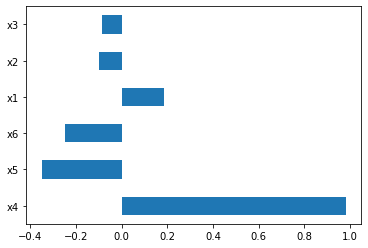

In [11]:
explanation.bar()

We can also get partial explanation.

Contribution of each variable directly involved within the decision policy.

In [12]:
explanation.rule_table()

,Contribution
lm,0.740
xgb,0.588
x4,0.537
tree,-0.500
x1,0.449
x2,0.000
x3,0.000
x5,0.000
x6,0.000


Contribution for model *lm*.

In [13]:
explanation.model_table('lm')

,Contribution
x5,-0.469564
x6,-0.334768
x3,0.152231
x2,-0.043436
x1,0.000000
x4,0.000000


<AxesSubplot:>

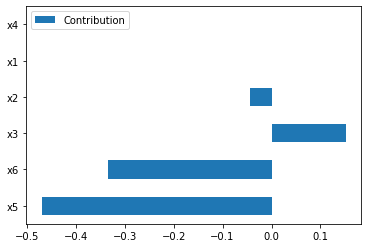

In [14]:
explanation.model_bar('lm')

In [15]:
explanation.model_table('xgb')

,Contribution
x1,-0.444206
x3,-0.340262
x2,-0.116675
x4,-0.091918
x5,-0.003646
x6,0.003292


In [16]:
explanation.model_table('tree')

,Contribution
x4,-1.0
x1,0.0
x2,0.0
x3,0.0
x5,0.0
x6,0.0


We may also wonder why 'dec1' was not made, i.e., why 'rul1' was not triggered.

In [17]:
explanation = explainer.explain(example, 'rul1')
explanation.table()

,Example,Contribution
x3,0.122378,-0.877473
x4,0.288903,0.765623
x2,0.277252,-0.754386
x5,0.207442,-0.377015
x6,0.300151,-0.266583
x1,0.799277,-0.166133


<AxesSubplot:>

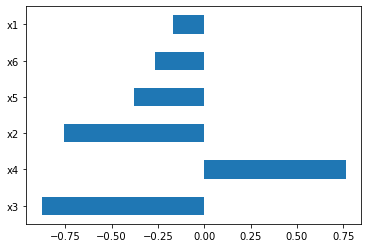

In [18]:
explanation.bar()

### LIME for the models

In [19]:
def lime_mapper(x):  # mapper needed for lime
    y = []
    x = x.as_map()[1]
    x.sort()
    y = [x[i][1] for i in range(len(x))]
    return np.array(y)

In [20]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(df.values, feature_names=df.columns, discretize_continuous=False, 
                                                 mode='regression')

lm_exp = lime_explainer.explain_instance(example, lm.predict, num_features=6, top_labels=1)
lm_exp = lm_exp.as_list()

xgb_exp = lime_explainer.explain_instance(example, xgb.predict, num_features=6, top_labels=1)
xgb_exp = xgb_exp.as_list()

tree_exp = lime_explainer.explain_instance(example, dtree.predict, num_features=6, top_labels=1)
tree_exp = tree_exp.as_list()

In [21]:
phi_lm = dict((x, y) for x, y in lm_exp)
phi_xgb = dict((x, y) for x, y in xgb_exp)
phi_tree = dict((x, y) for x, y in tree_exp)

In [22]:
phi_tree

{'x4': 224.4656638419963,
 'x1': -4.0959005188078645,
 'x6': 4.008176058000461,
 'x2': 2.8567800949787645,
 'x5': 0.9898777838010503,
 'x3': 0.7392767142474028}

In [23]:
phis = {'lm': phi_lm, 
        'xgb': phi_xgb,
        'tree': phi_tree}

In [24]:
explanation = explainer.explain(example, 'rul1', phis=phis)
explanation.table(num_features=6)

,Example,Contribution
x3,0.122378,-0.868881
x4,0.288903,-0.697561
x2,0.277252,-0.589926
x6,0.300151,0.348158
x5,0.207442,0.315199
x1,0.799277,-0.157844


In [25]:
explanation.model_table('lm')

,Contribution
x6,0.451904
x5,0.399552
x3,-0.099342
x2,0.049193
x1,0.000008
x4,0.000001


In [26]:
explanation.model_table('xgb')

,Contribution
x1,-0.459001
x3,0.227504
x4,0.159440
x2,0.150686
x5,-0.002952
x6,0.000417


In [27]:
explanation.model_table('tree')

,Contribution
x4,0.946491
x1,-0.017271
x6,0.016901
x2,0.012046
x5,0.004174
x3,0.003117


### Known contributions for models

In [28]:
phi_lm = {columns[i]: lm.coef_[i] for i in range(len(columns))}
xgb_score = xgb.get_booster().get_score(importance_type = 'gain')
phi_xgb = {columns[i]: xgb_score['f' + str(i)] for i in range(len(columns))}  # map for xgboost
tree_score = dtree.feature_importances_
phi_tree = {columns[i]: tree_score[i] for i in range(len(columns))}

In [29]:
phi_lm

{'x1': -7.555577399282871e-16,
 'x2': 0.9999999999999966,
 'x3': -1.9999999999999991,
 'x4': -9.658608607294428e-16,
 'x5': 8.000000000000002,
 'x6': 8.999999999999998}

In [30]:
phis = {'lm': phi_lm, 
        'xgb': phi_xgb,
        'tree': phi_tree}

In [31]:
explanation = explainer.explain(example, 'rul1', phis=phis)
explanation.table(num_features=6)

,Example,Contribution
x3,0.122378,-0.887060
x4,0.288903,-0.745644
x2,0.277252,-0.595881
x6,0.300151,0.360574
x5,0.207442,0.320834
x1,0.799277,0.213178


In [32]:
explanation.model_table('xgb')

,Contribution
x1,0.569994
x3,0.173636
x4,0.145336
x2,0.107269
x5,0.002231
x6,0.001534


In [33]:
explanation.model_table('tree')

,Contribution
x4,1.0
x1,0.0
x2,0.0
x3,0.0
x5,0.0
x6,0.0
